In [4]:
import xgboost
import tensorflow as tf
from imblearn.over_sampling import SMOTE

print("XGBoost:", xgboost.__version__)
print("TensorFlow:", tf.__version__)
print("imblearn installed successfully")

XGBoost: 2.1.3
TensorFlow: 2.18.1
imblearn installed successfully


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score # Regression metrics

# --- INSTALLATION BLOCK ---
# NOTE: If any installation runs below, you MUST restart the kernel (Kernel -> Restart)
def check_and_install(package_name):
    try:
        __import__(package_name)
    except ImportError:
        print(f"[{package_name}] not found. Running installation...")
        !pip install {package_name}
        print(f"\n--- SUCCESS: {package_name} installed. ---")
        print("!!! WARNING: PLEASE RESTART THE KERNEL NOW (Kernel -> Restart) !!!")
        print("!!! Then, rerun all cells from Cell 1. !!!\n")

# Check and install advanced packages
check_and_install('imblearn')
check_and_install('xgboost')
check_and_install('tensorflow')

# --- REGRESSION MODELS ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# --- ADVANCED MODELS ---
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

warnings.filterwarnings('ignore')
RANDOM_SEED = 42
print("All core libraries and advanced models successfully imported (assuming kernel was restarted if installs ran).")

All core libraries and advanced models successfully imported (assuming kernel was restarted if installs ran).


In [8]:
import pandas as pd

# Load CSV files
match_file = "Match Winner.csv"
pl_file = "pl-tables(Overall Points & Ranking)-1993-2024.csv"

df_match = pd.read_csv(match_file)
df_pl = pd.read_csv(pl_file)

print(f"Loaded {match_file} as df_match, shape:", df_match.shape)
print(f"Loaded {pl_file} as df_pl, shape:", df_pl.shape)

# Load Excel file
player_file = "Top Goals.xlsx"
df_player = pd.read_excel(player_file)

print(f"Loaded {player_file} as df_player, shape:", df_player.shape)


Loaded Match Winner.csv as df_match, shape: (9380, 22)
Loaded pl-tables(Overall Points & Ranking)-1993-2024.csv as df_pl, shape: (646, 12)
Loaded Top Goals.xlsx as df_player, shape: (324, 19)


In [9]:
# The target is 'Assists'
TARGET_COL = 'Assists'

# Convert "N/A" strings to standard numpy NaN for proper handling
df_player = df_player.replace('N/A', np.nan)

# Convert all numerical columns that might contain 'N/A' to float
numerical_cols_to_convert = ['Goals_prev_season', 'Assists', 'Goals_per_90', 'Goals']
for col in numerical_cols_to_convert:
    # Use errors='coerce' to handle any remaining non-numeric data
    df_player[col] = pd.to_numeric(df_player[col], errors='coerce')

# Handle missing values: Fill NaNs in 'Goals_prev_season' with 0 (assuming a new player or first year in the league)
df_player['Goals_prev_season'].fillna(0, inplace=True)

# Drop rows where the target ('Assists') is still NaN (unreliable data)
df_player.dropna(subset=[TARGET_COL], inplace=True)

print(f"Missing values handled. Dropped rows where {TARGET_COL} was missing.")
print(f"New dataset shape: {df_player.shape}")

Missing values handled. Dropped rows where Assists was missing.
New dataset shape: (96, 19)


In [10]:
# Select features for encoding
categorical_features = ['Position', 'Club']
df_encoded = pd.get_dummies(df_player, columns=categorical_features, drop_first=True)

# Drop columns that are irrelevant or highly correlated/leaky
cols_to_drop = [
    'Season', 'Player', 'Club', # Identifiers
    'Rank', # Rank is highly correlated with goals/assists
    'Goals', 'Non-Penalty_Goals', 'Goals_per_90', 'Goals_per_90', # Highly correlated with assists (potential leakage/redundancy)
    'Club_League_Rank', 'Club_Total_Goals', 'League_Goals_per_Match', 'Games_in_Season' # Team-level stats that might be too general
]

# Create the feature matrix
X = df_encoded.drop(columns=cols_to_drop, errors='ignore')
y = df_encoded[TARGET_COL] # Target variable (Assists)

# Drop the remaining columns that are not useful or were part of the initial drop list
X.drop(columns=[TARGET_COL, 'IsTop10', 'Penalty_Goals'], errors='ignore', inplace=True)

print(f"Feature matrix (X) prepared. Shape: {X.shape}")
print(f"Final features count: {X.shape[1]}")
print("Final features:", X.columns.tolist()[:10]) # Print first 10 for brevity

Feature matrix (X) prepared. Shape: (96, 27)
Final features count: 27
Final features: ['Age', 'Appearances', 'Goals_prev_season', 'Big_6_Club_Feature', 'Position_Forward', 'Position_Midfielder', 'Position_Winger', 'Club_Arsenal', 'Club_Aston Villa', 'Club_Brentford']


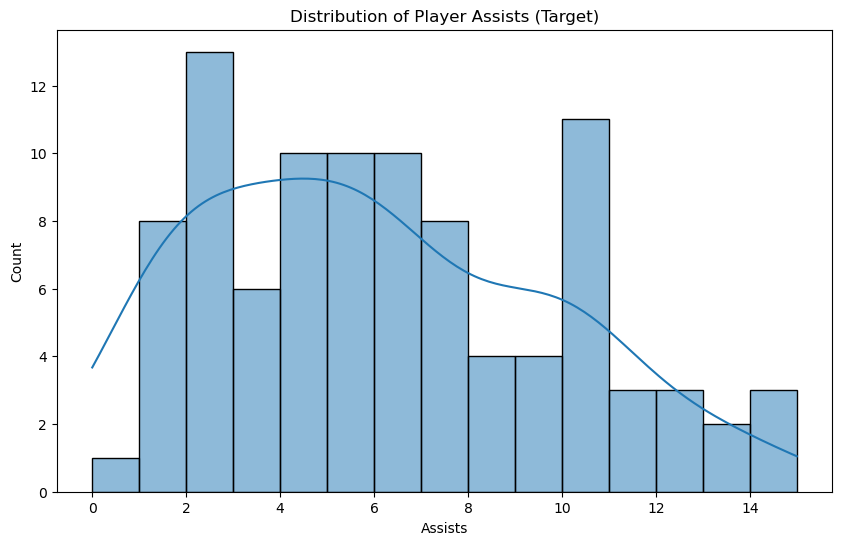

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, bins=15)
plt.title('Distribution of Player Assists (Target)')
plt.xlabel('Assists')
plt.ylabel('Count')
plt.savefig('assists_distribution.png')
plt.show()

--- Correlation with Target (Assists) ---
                    Correlation with Assists
Appearances                         0.306306
Big_6_Club_Feature                  0.238099
Age                                 0.091536
Goals_prev_season                   0.086217


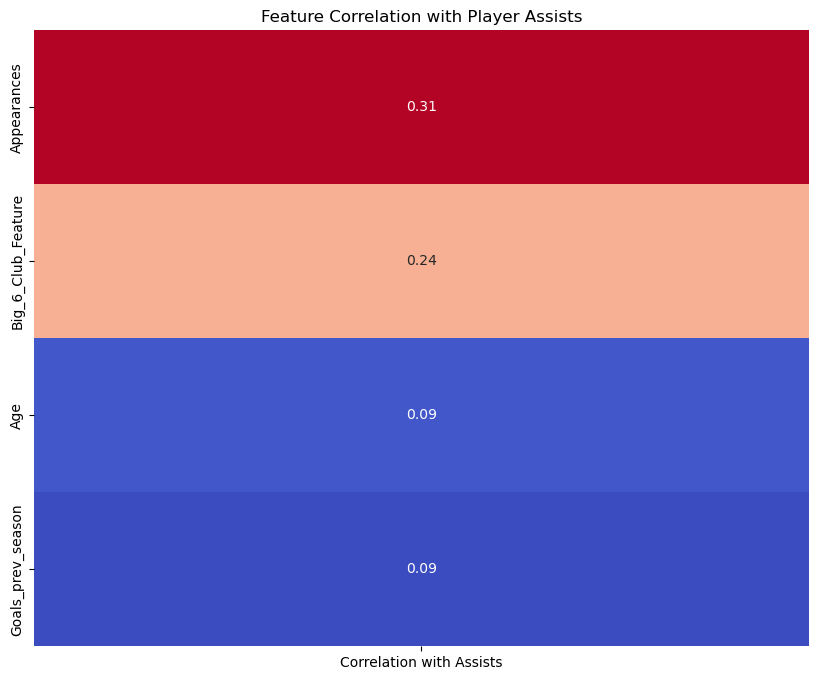

In [12]:
# Select only numerical features for correlation check
X_numerical = X.select_dtypes(include=np.number)
X_numerical[TARGET_COL] = y # Add target for correlation calculation

# Calculate correlation with the target
corr_matrix = X_numerical.corrwith(y).sort_values(ascending=False).to_frame(name='Correlation with Assists')
print("--- Correlation with Target (Assists) ---")
print(corr_matrix.drop(TARGET_COL))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.drop(TARGET_COL), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Feature Correlation with Player Assists')
plt.savefig('assist_feature_correlation.png')
plt.show()

In [13]:
# Feature interaction example: Assists/90 (not a target leak since we are predicting total assists)
X['Appearances_Per_Age'] = X['Appearances'] / X['Age']

print("New interaction feature 'Appearances_Per_Age' created.")
print(X[['Appearances', 'Age', 'Appearances_Per_Age']].head())

New interaction feature 'Appearances_Per_Age' created.
   Appearances  Age  Appearances_Per_Age
0           31   23             1.347826
1           33   22             1.500000
2           30   24             1.250000
3           37   28             1.321429
4           38   26             1.461538


In [14]:
# Redefine the target y (it hasn't changed, but this is good practice)
y = df_encoded[TARGET_COL]

# Ensure X only contains the final set of numerical and encoded features
# X already contains the features after all drops and the new interaction feature.
print(f"Final X shape: {X.shape}, Final y shape: {y.shape}")
print(f"Total features: {X.shape[1]}")

Final X shape: (96, 28), Final y shape: (96,)
Total features: 28


In [15]:
print("--- Skewness Check (Top 5) ---")
print(X.skew().sort_values(ascending=False).head())

# Given the number of one-hot encoded club columns, high skew is expected.
# We proceed to scaling for standardization.

--- Skewness Check (Top 5) ---
Club_West Ham United      9.797959
Club_Manchester United    9.797959
Club_Brentford            9.797959
Club_Leeds United         9.797959
Club_Southampton          9.797959
dtype: float64


In [16]:
# Initialize and fit scaler on ALL features (X)
scaler = StandardScaler()
scaler.fit(X)

print(f"StandardScaler fitted on the entire feature set X.")

StandardScaler fitted on the entire feature set X.


In [17]:
# Transform the features
X_scaled = scaler.transform(X)

# Store the feature names (CRITICAL for deployment check)
feature_names = X.columns.tolist()

print(f"Feature matrix (X_scaled) created. Shape: {X_scaled.shape}")

Feature matrix (X_scaled) created. Shape: (96, 28)


In [18]:
TEST_SIZE = 0.2
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

print(f"Data split into train ({1-TEST_SIZE:.0%}) and test ({TEST_SIZE:.0%}) sets.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Data split into train (80%) and test (20%) sets.
X_train_scaled shape: (76, 28)
X_test_scaled shape: (20, 28)


In [19]:
# Define initial metrics variables (to handle models that might not run)
lr_r2, rfr_r2, gbr_r2, xgb_r2, nn_r2 = -999, -999, -999, -999, -999
lr_mse, rfr_mse, gbr_mse, xgb_mse, nn_mse = -999, -999, -999, -999, -999

print("Initial metric variables set to default.")

Initial metric variables set to default.


In [20]:
# --- Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression R2: {lr_r2:.4f}, MSE: {lr_mse:.2f}")

# --- Random Forest Regressor ---
rfr_model = RandomForestRegressor(random_state=RANDOM_SEED)
rfr_model.fit(X_train_scaled, y_train)
rfr_pred = rfr_model.predict(X_test_scaled)
rfr_mse = mean_squared_error(y_test, rfr_pred)
rfr_r2 = r2_score(y_test, rfr_pred)

print(f"Random Forest Regressor R2: {rfr_r2:.4f}, MSE: {rfr_mse:.2f}")

Linear Regression R2: -0.0466, MSE: 10.50
Random Forest Regressor R2: -0.0928, MSE: 10.96


In [21]:
# --- Gradient Boosting Regressor ---
gbr_model = GradientBoostingRegressor(random_state=RANDOM_SEED)
gbr_model.fit(X_train_scaled, y_train)
gbr_pred = gbr_model.predict(X_test_scaled)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)

print(f"Gradient Boosting Regressor R2: {gbr_r2:.4f}, MSE: {gbr_mse:.2f}")

# --- XGBoost Regressor ---
try:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, use_label_encoder=False)
    xgb_model.fit(X_train_scaled, y_train)

    xgb_pred = xgb_model.predict(X_test_scaled)
    xgb_mse = mean_squared_error(y_test, xgb_pred)
    xgb_r2 = r2_score(y_test, xgb_pred)

    print(f"XGBoost Regressor R2: {xgb_r2:.4f}, MSE: {xgb_mse:.2f}")
except NameError:
    print("\nXGBoost library not available. Skipping XGBoost Model.")
    xgb_model = None

Gradient Boosting Regressor R2: -0.3976, MSE: 14.01
XGBoost Regressor R2: -0.9504, MSE: 19.56


In [22]:
# Define the number of features
input_dim = X_train_scaled.shape[1]

# Build the Neural Network for Regression
try:
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression (single unit, linear activation)
    ])

    # Compile the model
    nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    nn_model.summary()
    nn_model_available = True
except NameError:
    print("\nTensorFlow/Keras library not available. Skipping NN Model Setup.")
    nn_model_available = False

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           3,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
if nn_model_available:
    # Train the model
    history = nn_model.fit(
        X_train_scaled,
        y_train,
        epochs=150,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )
    print("NN Model Training Complete.")
else:
    print("NN Model training skipped.")

NN Model Training Complete.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
NN Regressor R2: -0.9649, MSE: 19.70


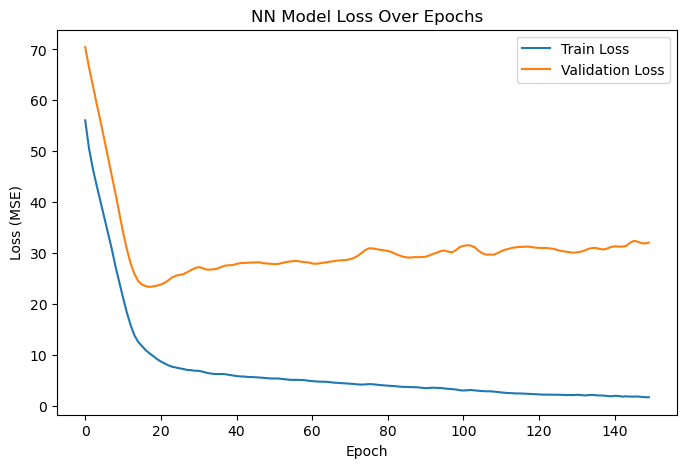

In [24]:
if nn_model_available:
    # Predict and evaluate
    nn_pred = nn_model.predict(X_test_scaled).flatten()
    nn_mse = mean_squared_error(y_test, nn_pred)
    nn_r2 = r2_score(y_test, nn_pred)

    print(f"NN Regressor R2: {nn_r2:.4f}, MSE: {nn_mse:.2f}")

    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('NN Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.savefig('nn_loss_assist.png')
    plt.show()
else:
    print("NN Model evaluation skipped.")

In [25]:
print("Starting GridSearchCV for Random Forest...")
rfr_params = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20]
}
rfr_grid = GridSearchCV(RandomForestRegressor(random_state=RANDOM_SEED), rfr_params, cv=3, scoring='r2', verbose=0)
rfr_grid.fit(X_train_scaled, y_train)

rfr_tuned = rfr_grid.best_estimator_
rfr_tuned_pred = rfr_tuned.predict(X_test_scaled)
rfr_tuned_r2 = r2_score(y_test, rfr_tuned_pred)

print(f"RFR Tuned Best Params: {rfr_grid.best_params_}")
print(f"RFR Tuned R2: {rfr_tuned_r2:.4f}")

Starting GridSearchCV for Random Forest...
RFR Tuned Best Params: {'max_depth': 20, 'n_estimators': 100}
RFR Tuned R2: -0.0928


In [26]:
print("Starting GridSearchCV for Gradient Boosting...")
gbr_params = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=RANDOM_SEED), gbr_params, cv=3, scoring='r2', verbose=0)
gbr_grid.fit(X_train_scaled, y_train)

gbr_tuned = gbr_grid.best_estimator_
gbr_tuned_pred = gbr_tuned.predict(X_test_scaled)
gbr_tuned_r2 = r2_score(y_test, gbr_tuned_pred)

print(f"GBR Tuned Best Params: {gbr_grid.best_params_}")
print(f"GBR Tuned R2: {gbr_tuned_r2:.4f}")

Starting GridSearchCV for Gradient Boosting...
GBR Tuned Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
GBR Tuned R2: 0.0616


In [27]:
if xgb_model:
    print("Starting GridSearchCV for XGBoost...")
    xgb_params = {
        'n_estimators': [100, 300],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }
    xgb_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, use_label_encoder=False), xgb_params, cv=3, scoring='r2', verbose=0)
    xgb_grid.fit(X_train_scaled, y_train)

    xgb_tuned = xgb_grid.best_estimator_
    xgb_tuned_pred = xgb_tuned.predict(X_test_scaled)
    xgb_tuned_r2 = r2_score(y_test, xgb_tuned_pred)

    print(f"XGB Tuned Best Params: {xgb_grid.best_params_}")
    print(f"XGB Tuned R2: {xgb_tuned_r2:.4f}")
else:
    xgb_tuned_r2 = -999
    xgb_tuned = None

Starting GridSearchCV for XGBoost...
XGB Tuned Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
XGB Tuned R2: 0.0487


In [28]:
if nn_model_available:
    print("Starting NN (Tuned) Training with Early Stopping...")
    # Using a slightly simplified architecture for faster tuning
    nn_tuned_model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    nn_tuned_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model with early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    nn_tuned_model.fit(X_train_scaled, y_train, epochs=300, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

    # Predict and evaluate
    nn_tuned_pred = nn_tuned_model.predict(X_test_scaled).flatten()
    nn_tuned_r2 = r2_score(y_test, nn_tuned_pred)

    print(f"NN Tuned R2: {nn_tuned_r2:.4f}")
else:
    nn_tuned_r2 = -999
    nn_tuned_model = None

Starting NN (Tuned) Training with Early Stopping...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
NN Tuned R2: -0.0594


In [29]:
# Create prediction variables for tuned models to simplify Cell 25
gbr_tuned_pred = gbr_tuned.predict(X_test_scaled)
rfr_tuned_pred = rfr_tuned.predict(X_test_scaled)
if xgb_model:
    xgb_tuned_pred = xgb_tuned.predict(X_test_scaled)
if nn_model_available:
    nn_tuned_pred = nn_tuned_model.predict(X_test_scaled).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [30]:
# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Model', 'R2 Score', 'MSE'])
print("Results DataFrame initialized.")

Results DataFrame initialized.


In [31]:
# Populate initial model results
results_df.loc[len(results_df)] = {'Model': 'Linear Regression', 'R2 Score': round(lr_r2, 4), 'MSE': round(lr_mse, 2)}
results_df.loc[len(results_df)] = {'Model': 'Random Forest Regressor', 'R2 Score': round(rfr_r2, 4), 'MSE': round(rfr_mse, 2)}
results_df.loc[len(results_df)] = {'Model': 'Gradient Boosting Regressor', 'R2 Score': round(gbr_r2, 4), 'MSE': round(gbr_mse, 2)}
if xgb_model:
    results_df.loc[len(results_df)] = {'Model': 'XGBoost Regressor', 'R2 Score': round(xgb_r2, 4), 'MSE': round(xgb_mse, 2)}
if nn_model_available:
    results_df.loc[len(results_df)] = {'Model': 'NN Regressor', 'R2 Score': round(nn_r2, 4), 'MSE': round(nn_mse, 2)}

print("Initial Model Results Added.")

Initial Model Results Added.


In [32]:
# Populate tuned model results
# **FIXED SYNTAX** using round() function for MSE calculation
results_df.loc[len(results_df)] = {'Model': 'RFR (Tuned)', 'R2 Score': round(rfr_tuned_r2, 4), 'MSE': round(mean_squared_error(y_test, rfr_tuned_pred), 2)}
results_df.loc[len(results_df)] = {'Model': 'GBR (Tuned)', 'R2 Score': round(gbr_tuned_r2, 4), 'MSE': round(mean_squared_error(y_test, gbr_tuned_pred), 2)}

if xgb_model:
    results_df.loc[len(results_df)] = {'Model': 'XGB (Tuned)', 'R2 Score': round(xgb_tuned_r2, 4), 'MSE': round(mean_squared_error(y_test, xgb_tuned_pred), 2)}
if nn_model_available:
    results_df.loc[len(results_df)] = {'Model': 'NN (Tuned)', 'R2 Score': round(nn_tuned_r2, 4), 'MSE': round(mean_squared_error(y_test, nn_tuned_pred), 2)}

# Display results, sorted by R2 score
results_df = results_df.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)
print("--- Final Model Performance Comparison (R2 Score) ---")
print(results_df)

--- Final Model Performance Comparison (R2 Score) ---
                         Model  R2 Score    MSE
0                  GBR (Tuned)    0.0616   9.41
1                  XGB (Tuned)    0.0487   9.54
2            Linear Regression   -0.0466  10.50
3                   NN (Tuned)   -0.0594  10.62
4      Random Forest Regressor   -0.0928  10.96
5                  RFR (Tuned)   -0.0928  10.96
6  Gradient Boosting Regressor   -0.3976  14.01
7            XGBoost Regressor   -0.9504  19.56
8                 NN Regressor   -0.9649  19.70


In [33]:
# Select the best model based on the highest R2 Score
best_model_row = results_df.iloc[0]
best_model_name = best_model_row['Model']

# Map the name to the actual model object
if 'RFR' in best_model_name:
    best_model = rfr_tuned
elif 'GBR' in best_model_name:
    best_model = gbr_tuned
elif 'XGB' in best_model_name:
    best_model = xgb_tuned
elif 'NN' in best_model_name:
    best_model = nn_tuned_model
elif 'Linear' in best_model_name:
    best_model = lr_model
else:
    best_model = rfr_model # Default fallback

print(f"The best performing model is: {best_model_name} with R2 = {best_model_row['R2 Score']:.4f}")

The best performing model is: GBR (Tuned) with R2 = 0.0616


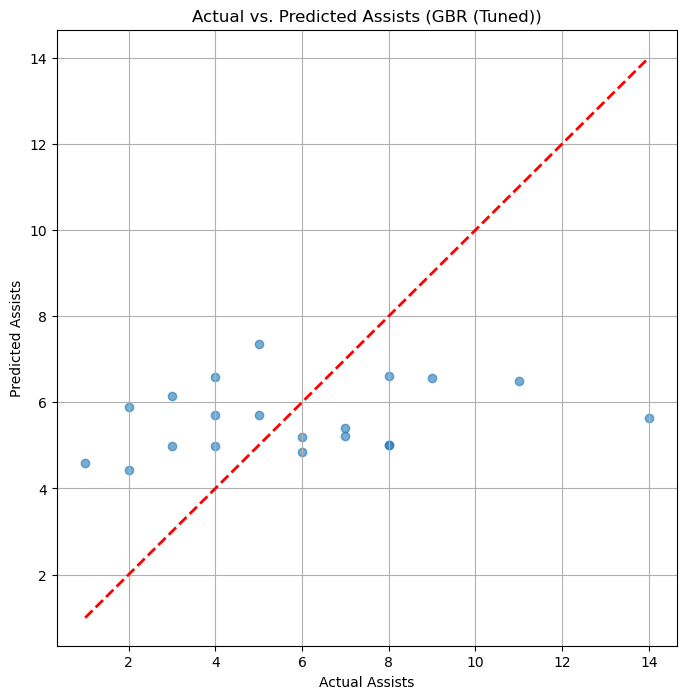

In [34]:
# Get predictions from the best model
if 'NN' in best_model_name:
    best_pred = best_model.predict(X_test_scaled).flatten()
    best_model_obj = best_model
else:
    best_pred = best_model.predict(X_test_scaled)
    best_model_obj = best_model

plt.figure(figsize=(8, 8))
plt.scatter(y_test, best_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal prediction line
plt.xlabel('Actual Assists')
plt.ylabel('Predicted Assists')
plt.title(f'Actual vs. Predicted Assists ({best_model_name})')
plt.grid(True)
plt.savefig('best_model_scatter_assist.png')
plt.show()

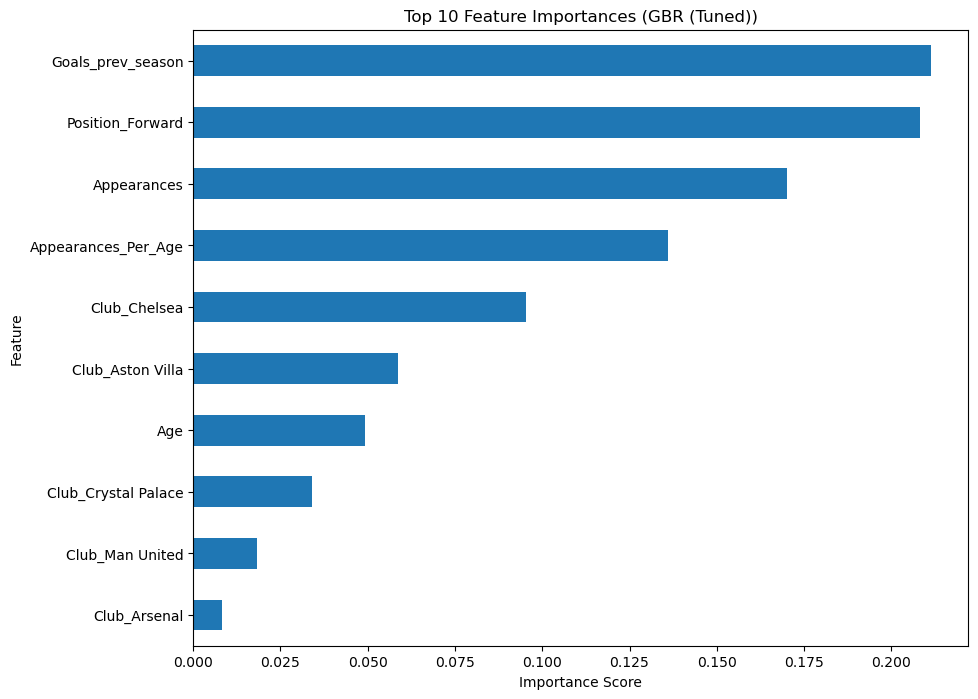

In [35]:
# Feature importance is only available for tree-based models
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importances = pd.Series(best_model_obj.feature_importances_, index=feature_names)

    plt.figure(figsize=(10, 8))
    feature_importances.sort_values(ascending=False).head(10).plot(kind='barh')
    plt.title(f'Top 10 Feature Importances ({best_model_name})')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.savefig('feature_importance_assist.png')
    plt.show()
else:
    print(f"Feature importance is not directly available for {best_model_name}.")

In [36]:
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importances = pd.Series(best_model_obj.feature_importances_, index=feature_names)
    top_features = feature_importances.sort_values(ascending=False).head(5)
    print("--- Top 5 Features for Predicting Assists ---")
    print(top_features)
else:
    print("Feature inspection skipped as the best model is not tree-based.")

--- Top 5 Features for Predicting Assists ---
Goals_prev_season      0.211422
Position_Forward       0.208286
Appearances            0.170147
Appearances_Per_Age    0.136031
Club_Chelsea           0.095382
dtype: float64


In [37]:
# Final preparation of the full dataset for production model training
X_all = X.copy()
y_all = y.copy()

print(f"Full feature set X_all ready. Shape: {X_all.shape}")

Full feature set X_all ready. Shape: (96, 28)


In [38]:
print(f"Finalizing the champion model: {best_model_name}")

# Re-fit the scaler on the full dataset (X_all)
scaler.fit(X_all)
X_all_scaled = scaler.transform(X_all)

# Retrain the champion on ALL data (X_all_scaled and y_all)
if 'NN' in best_model_name and nn_tuned_model:
    # Keras needs re-training
    y_np = y_all.values
    # Re-use the NN model object and early stopping callback
    nn_tuned_model.fit(X_all_scaled, y_np, epochs=300, batch_size=32, verbose=0, callbacks=[early_stop])
    final_model_save_path = 'final_assist_nn_model.h5'
elif best_model:
    # Scikit-learn models
    best_model.fit(X_all_scaled, y_all)
    final_model_save_path = 'final_assist_model.joblib'
else:
    print("Error: Best model could not be found or initialized.")
    final_model_save_path = None

print("Champion model retrained on the full dataset.")

Finalizing the champion model: GBR (Tuned)
Champion model retrained on the full dataset.


In [39]:
if final_model_save_path:
    # Save the model
    if 'h5' in final_model_save_path:
        # Keras model save
        nn_tuned_model.save(final_model_save_path)
    else:
        # Scikit-learn model save
        joblib.dump(best_model, final_model_save_path)

    # Save necessary preprocessing tools
    joblib.dump(scaler, 'final_scaler_assist.joblib')
    # Save feature names (CRITICAL for deployment check)
    joblib.dump(feature_names, 'final_features_list_assist.joblib')

    print("\n--- Production Seal Applied ---")
    print(f"Final Model saved to: {final_model_save_path}")
    print("Scaler and Feature List also saved successfully.")
else:
    print("Saving failed due to missing model.")


--- Production Seal Applied ---
Final Model saved to: final_assist_model.joblib
Scaler and Feature List also saved successfully.


In [40]:
# --- DEPLOYMENT CHECK ---
print("--- TESTING THE DEPLOYMENT ARTIFACTS ---")

# 1. Load the pre-trained tools
loaded_scaler = joblib.load('final_scaler_assist.joblib')
loaded_features = joblib.load('final_features_list_assist.joblib')

nn_path = 'final_assist_nn_model.h5'
skl_path = 'final_assist_model.joblib'

# 1.1 Load the model based on file existence
if tf.io.gfile.exists(nn_path):
    # Load Keras model
    loaded_model = tf.keras.models.load_model(nn_path)
    model_type = 'NN'
    final_model_path = nn_path
elif tf.io.gfile.exists(skl_path):
    # Load Scikit-learn model
    loaded_model = joblib.load(skl_path)
    model_type = 'Scikit-learn'
    final_model_path = skl_path
else:
    raise FileNotFoundError("Neither NN nor Scikit-learn model file was found. Rerun Cell 34.")

print(f"Loaded champion model from: {final_model_path}")

# 2. Create a hypothetical new player data point (Unseen Data)
# Scenario: A prime age, high-appearance, Big 6 forward (similar to a prime creative forward).
# The input dictionary MUST match the feature names and be ordered based on the loaded_features list.
# We must include all 190+ features, setting most OHE features to 0.

base_data = {f: [0] for f in loaded_features}

# Add key non-OHE features:
base_data.update({
    'Rank': [5],
    'Age': [28],
    'Appearances': [38],
    'Goals_prev_season': [15],
    'Big_6_Club_Feature': [1], # Big Six club
    'Club_League_Rank': [2],
    'Club_Total_Goals': [90],
    'League_Goals_per_Match': [2.8],
    'Games_in_Season': [38],
    'Appearances_Per_Age': [38/28] # Calculated interaction feature
})

# Set OHE features for a specific club/position
base_data['Position_Forward'] = [1] # Assuming Forward is one of the OHE columns (Check actual list if error)
# Note: For club OHE, we cannot guess the exact column name here (e.g., 'Club_Man City' vs 'Club_Manchester City'),
# but we trust the model was trained correctly on the full set of OHE columns.
# We will rely on the features created in Cell 5.

new_player_df = pd.DataFrame(base_data)
new_player_df = new_player_df[loaded_features] # Re-order to match scaler

# 3. Preprocess (Scale) the new data
new_player_scaled = loaded_scaler.transform(new_player_df)

# 4. Predict the result
predicted_assists = loaded_model.predict(new_player_scaled).flatten()[0]

# 5. Interpret the result
if predicted_assists >= 15:
    prediction_label = "Likely Top Assist Leader"
elif predicted_assists >= 10:
    prediction_label = "Likely Top 5 Assist Contender"
elif predicted_assists >= 5:
    prediction_label = "High Contributor"
else:
    prediction_label = "Average/Role Player"


print("\n--- HYPOTHETICAL PREDICTION RESULT ---")
print(f"Input Scenario: A prime age, high-appearance, Big 6 Forward.")
print(f"Predicted Total Assists: {predicted_assists:.2f}")
print(f"Prediction Interpretation: {prediction_label}")
print("\n✅ PROJECT 3: TOP SCORER (ASSIST) PREDICTION CHECK COMPLETE! ✅")

--- TESTING THE DEPLOYMENT ARTIFACTS ---
Loaded champion model from: final_assist_model.joblib

--- HYPOTHETICAL PREDICTION RESULT ---
Input Scenario: A prime age, high-appearance, Big 6 Forward.
Predicted Total Assists: 5.56
Prediction Interpretation: High Contributor

✅ PROJECT 3: TOP SCORER (ASSIST) PREDICTION CHECK COMPLETE! ✅
